# Object Detecion by CNN Regression using Random Areas

## Download data

In [1]:
!wget https://github.com/vladiant/ObjectDetectSamples/raw/main/RegressionCNN/random_iou_data.csv

--2022-03-19 19:16:46--  https://github.com/vladiant/ObjectDetectSamples/raw/main/RegressionCNN/random_iou_data.csv
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vladiant/ObjectDetectSamples/main/RegressionCNN/random_iou_data.csv [following]
--2022-03-19 19:16:46--  https://raw.githubusercontent.com/vladiant/ObjectDetectSamples/main/RegressionCNN/random_iou_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1859885 (1.8M) [text/plain]
Saving to: ‘random_iou_data.csv’

random_iou_data.csv 100%[===================>]   1.77M  --.-KB/s    in 0.07s   

2022-03-19 19:16:47 (25.3 MB/s) - ‘rando

In [2]:
!wget https://github.com/vladiant/ObjectDetectSamples/raw/main/ImageData/Images.zip
!unzip -q Images.zip

--2022-03-19 19:16:48--  https://github.com/vladiant/ObjectDetectSamples/raw/main/ImageData/Images.zip
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vladiant/ObjectDetectSamples/main/ImageData/Images.zip [following]
--2022-03-19 19:16:49--  https://raw.githubusercontent.com/vladiant/ObjectDetectSamples/main/ImageData/Images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12680736 (12M) [application/zip]
Saving to: ‘Images.zip’

Images.zip          100%[===================>]  12.09M  --.-KB/s    in 0.1s    

2022-03-19 19:16:50 (98.4 MB/s) - ‘Images.zip’ saved [12680736/12680736]



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsolutePercentageError

In [6]:
import cv2 as cv
from os import path

## Setup

In [7]:
BATCH_SIZE = 128
IMAGE_SIZE = (32, 32)

Read segmentation data

In [8]:
df = pd.read_csv("random_iou_data.csv", skipinitialspace=True)
print(f"Data length {len(df)}")

Data length 28838


Shuffle

In [9]:
df = df.sample(frac=1)
split_size = round(len(df)*0.95)
df_val = df[split_size:]
df = df[:split_size]

In [10]:
df.head()

,IOU,x1,x2,y1,y2,filename
18074,0.143391,202,245,159,238,./Images/airplane_084.jpg
2018,0.132191,126,196,85,125,./Images/airplane_268.jpg
5633,0.001974,83,171,75,134,./Images/airplane_272.jpg
23696,0.044069,156,211,62,226,./Images/airplane_407.jpg
10325,0.097303,169,231,19,141,./Images/airplane_425.jpg


In [11]:
def preprocess_image(x):
    # Normalize
    x = tf.cast(x, tf.float32) / 255.0

    # 'RGB'->'BGR'
    x = x[..., ::-1]
    return x

In [12]:
def read_and_prepare_image(image_filename, x1, x2, y1, y2, iou):
    # Get images
    image = tf.io.read_file(image_filename)
    image_decoded = tf.image.rgb_to_grayscale(tf.image.decode_jpeg(image))
 
    # Crop
    image_cropped = image_decoded[y1:y2, x1:x2]
    
    # Resize
    image_resized = tf.image.resize(image_cropped, IMAGE_SIZE)
    
    image_tensor = preprocess_image(image_resized)
    # tf.print(image_tensor)
    
    return image_tensor, iou

In [13]:
def initialize_tf_dataset(data, should_batch = True, should_repeat = True):
    dataset_initial = tf.data.Dataset.from_tensor_slices((data.filename.values,\
                                                          data.x1.values,\
                                                          data.x2.values,\
                                                          data.y1.values,\
                                                          data.y2.values,\
                                                          data.IOU.values,))
    dataset_mapped = dataset_initial.map(read_and_prepare_image)
    dataset_shuffled = dataset_mapped.shuffle(buffer_size = len(data))
    
    if should_batch:
        dataset = dataset_shuffled.batch(BATCH_SIZE)
    else:
        dataset = dataset_shuffled.batch(len(data))
        
    if should_repeat:
        dataset = dataset.repeat()
    return dataset

In [14]:
train_data = initialize_tf_dataset(df)

In [15]:
val_data = initialize_tf_dataset(df_val)

Sample iterator usage:
```
iterator = iter(train_data)
im = iterator.get_next()
tf.print(im[1][0])
plt.imshow(im[0][0], cmap='gray')
```

In [16]:
# https://pyimagesearch.com/2019/01/28/keras-regression-and-cnns/
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1
    
    # define the model input
    inputs = Input(shape=inputShape)
    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs
        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)
    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)
    # construct the CNN
    model = Model(inputs, x)
    # return the CNN
    return model

In [17]:
model = create_cnn(32, 32, 1, regress=True)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        160       
                                                                 
 activation (Activation)     (None, 32, 32, 16)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640  

In [19]:
model.compile(optimizer=Adam(), loss=MeanAbsolutePercentageError())

In [20]:
history = model.fit(train_data,\
                    epochs = 40,\
                    steps_per_epoch=len(df)//BATCH_SIZE,\
                    validation_data=val_data,
                    validation_steps=len(df_val)//BATCH_SIZE)

Epoch 1/40
214/214 [==============================] - 59s 19ms/step - loss: 625.8351 - val_loss: 99.7960
Epoch 2/40
214/214 [==============================] - 32s 151ms/step - loss: 228.9279 - val_loss: 1829.7388
Epoch 3/40
214/214 [==============================] - 34s 161ms/step - loss: 150.5634 - val_loss: 95.3596
Epoch 4/40
214/214 [==============================] - 33s 153ms/step - loss: 175.9636 - val_loss: 93.4682
Epoch 5/40
214/214 [==============================] - 33s 153ms/step - loss: 107.2638 - val_loss: 135.6114
Epoch 6/40
214/214 [==============================] - 33s 153ms/step - loss: 142.8307 - val_loss: 91.8831
Epoch 7/40
214/214 [==============================] - 32s 151ms/step - loss: 100.6419 - val_loss: 93.9667
Epoch 8/40
214/214 [==============================] - 32s 151ms/step - loss: 97.7001 - val_loss: 90.9928
Epoch 9/40
214/214 [==============================] - 33s 154ms/step - loss: 95.2745 - val_loss: 88.0885
Epoch 10/40
214/214 [=========================

In [21]:
model.save("regression_random.h5")

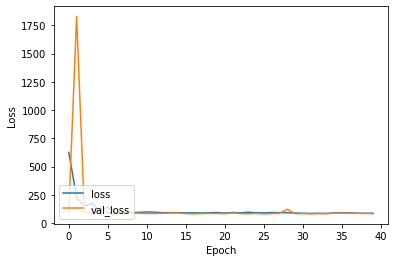

In [22]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower left')

In [23]:
images_path = "./Images"
image = "Planes11.jpg"

In [24]:
image = cv.imread(path.join(images_path,image))
imout = image.copy()

In [25]:
# Segmentation
ssresults = list()
for _ in range(1000):
    x = np.random.randint(low=0, high=imout.shape[1] - 32)
    y = np.random.randint(low=0, high=imout.shape[0] - 32)
    w = np.random.randint(low=32, high=imout.shape[1] - x)
    h = np.random.randint(low=32, high=imout.shape[0] - y)
    ssresults.append((x, y, w, h))

In [26]:
# Check segments
plane_segments = []
for result in ssresults:
    x,y,w,h = result
    timage = cv.cvtColor(image[y:y+h,x:x+w], cv.COLOR_BGR2GRAY)
    resized = cv.resize(timage,(32,32), interpolation=cv.INTER_CUBIC)
    
    # predict
    tf_image = preprocess_image(tf.convert_to_tensor(resized, dtype=tf.float32))
#     tf.print(tf_image)
#     plt.imshow(tf_image, cmap='gray')
#     break

    images_to_model = np.asarray([tf_image])
    score = model.predict(images_to_model)[0][0]

    # Draw segments with airplanes
    if score > 0.2:
        print(score)
        plane_segments.append((x,y,w,h))
        cv.rectangle(imout,(x,y),(x+w,y+h),(0,255,0),1)

0.2421134
0.22123243
0.2319176
0.25298423
0.2184517
0.29382172
0.28673095
0.23447143
0.20611499
0.2514891
0.20810741
0.25148445
0.23254345
0.24754097
0.20869263
0.23275432
0.2732237
0.2334013
0.21886899
0.28141463


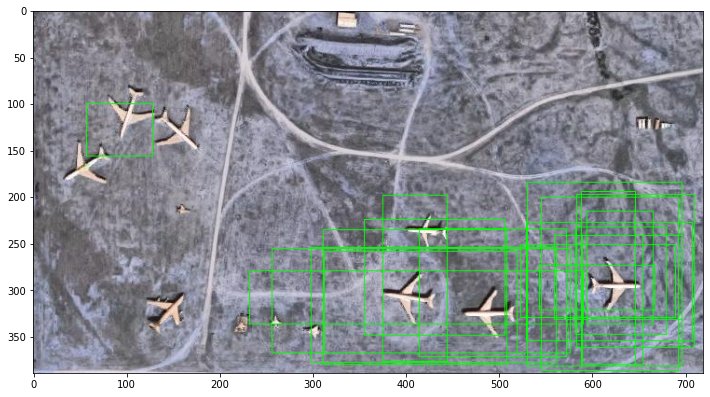

In [27]:
plt.figure(figsize=(12, 10))
plt.imshow(imout)
plt.show()

In [28]:
cv.setUseOptimized(True);
ss = cv.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [29]:
imout = image.copy()

In [30]:
# Segmentation
ss.setBaseImage(image)
# switchToSelectiveSearchFast, switchToSelectiveSearchQuality, switchToSingleStrategy
ss.switchToSingleStrategy()
ssresults = ss.process()

In [31]:
# Check segments
plane_segments = []
for result in ssresults:
    x,y,w,h = result
    timage = cv.cvtColor(image[y:y+h,x:x+w], cv.COLOR_BGR2GRAY)
    resized = cv.resize(timage,(32,32), interpolation=cv.INTER_CUBIC)
    
    # predict
    tf_image = preprocess_image(tf.convert_to_tensor(resized, dtype=tf.float32))
#     tf.print(tf_image)
#     plt.imshow(tf_image, cmap='gray')
#     break

    images_to_model = np.asarray([tf_image])
    score = model.predict(images_to_model)[0][0]

    # Draw segments with airplanes
    if score > 0.2:
        print(score)
        plane_segments.append((x,y,w,h))
        cv.rectangle(imout,(x,y),(x+w,y+h),(0,255,0),1)

0.22816542
0.26664948
0.25661838
0.29472762
0.29734612
0.22410433
0.24892315
0.23485504


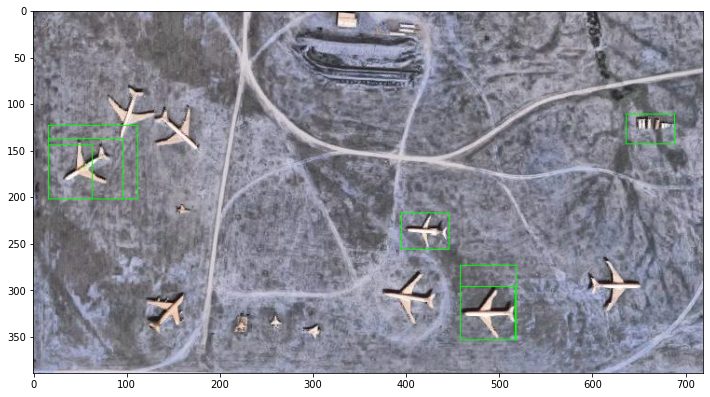

In [32]:
plt.figure(figsize=(12, 10))
plt.imshow(imout)
plt.show()